#  **Import libraries**

In [ ]:
import tensorflow as tf
import IPython.display as display
import PIL
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# **Load image data**

In [ ]:
data_dir = '/kaggle/input/mpdata/folder - Copy'
ds_name = 'Tomato dataset'
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 1253)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 1253)

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.keras import balanced_batch_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Assuming you have already defined your train_df, valid_df, and test_df dataframes

# Splitting the data into train, validation, and test sets
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1253)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=1253)

# Define constants
batch_size = 40
img_size = (256, 256)
channels = 3

# Define image shape
img_shape = (img_size[0], img_size[1], channels)

# Calculate test batch size
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Define image preprocessing function
def scalar(img):
    return img

# Define image data generators
tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            rescale=1.0 / 255,
#                             rotation_range=40,
#                             width_shift_range=0.2,
#                             height_shift_range=0.2,
#                             zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function=scalar,
                            rescale=1.0 / 255,
                            horizontal_flip=True,
                            vertical_flip=True)

# Oversample and undersample the training data
oversample = RandomOverSampler(sampling_strategy='auto', random_state=1253)
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=1253)

X_train, y_train = oversample.fit_resample(train_df[['filepaths']], train_df['labels'])
X_train, y_train = undersample.fit_resample(X_train, y_train)

train_resampled_df = pd.DataFrame({'filepaths': X_train.squeeze(), 'labels': y_train})

# Define image data generators for resampled training data
train_resampled_gen = tr_gen.flow_from_dataframe(train_resampled_df,
                                                 x_col='filepaths',
                                                 y_col='labels',
                                                 target_size=img_size,
                                                 class_mode='categorical',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=test_batch_size)

# Now you can use train_resampled_gen in place of train_gen in your training loop


Using TensorFlow backend.


Found 22510 validated image filenames belonging to 5 classes.
Found 2866 validated image filenames belonging to 5 classes.
Found 2867 validated image filenames belonging to 5 classes.


In [ ]:
# batch_size = 40
# img_size = (256, 256)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)


# ts_length = len(test_df)
# test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size


# def scalar(img):
#     return img

# tr_gen = ImageDataGenerator(preprocessing_function= scalar,
#                             rescale=1.0/255,

#                             rotation_range=40,
#                             width_shift_range=0.2,
#                             height_shift_range=0.2,
# #                             brightness_range=[0.4,0.6],
#                             zoom_range=0.3,
#                             horizontal_flip=True,
#                             vertical_flip=True)

# ts_gen = ImageDataGenerator(preprocessing_function= scalar,
#                             rescale=1.0/255,
# #                            rotation_range=40,
# #                            width_shift_range=0.2,
# #                            height_shift_range=0.2,
# #                            brightness_range=[0.4,0.6],
# #                            zoom_range=0.3,
#                            horizontal_flip=True,
#                            vertical_flip=True)

# train_gen = tr_gen.flow_from_dataframe(train_df,
#                                        x_col = 'filepaths',
#                                        y_col= 'labels',
#                                        target_size = img_size,
#                                        class_mode= 'categorical',
#                                        color_mode= 'rgb',
#                                        shuffle= True,
#                                        batch_size=batch_size)

# valid_gen = ts_gen.flow_from_dataframe(valid_df,
#                                        x_col= 'filepaths',
#                                        y_col= 'labels',
#                                        target_size= img_size,
#                                        class_mode= 'categorical',
#                                        color_mode= 'rgb',
#                                        shuffle= True,
#                                        batch_size= batch_size)

# # Note: we will use custom test_batch_size, and make shuffle= false
# test_gen = ts_gen.flow_from_dataframe(test_df,
#                                       x_col= 'filepaths',
#                                       y_col= 'labels',
#                                       target_size= img_size,
#                                       class_mode= 'categorical',
#                                       color_mode= 'rgb',
#                                       shuffle= False,
#                                       batch_size= test_batch_size)


### Convolution network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

num_classes = 5

model_mango = Sequential([
    Conv2D(64, (2, 2), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(128, (2, 2), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(128, (2, 2), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(128, (2, 2), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

#     Conv2D(128, (2, 2), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),
#     BatchNormalization(),

    Dropout(0.5),

    Flatten(),

#     Dense(32, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
#     Dropout(0.5),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dense(16,activation='relu'),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])


In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001  # Adjust this value as needed

optimizer = Adam(learning_rate=learning_rate)

model_mango.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])


In [ ]:
# model_mango.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
model_mango.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 128)     32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       6

### Larning rate reducing by 0.1  every 10 epochs on plateau
### Early stopping to stop learning after 24 epochs on plateau (with restoring best model)
### Model checkpoint to save best model to file

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#rlr = ReduceLROnPlateau(patience=10, verbose=1)
es = EarlyStopping(patience=24, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('model_tomato.keras', save_best_only=True, verbose=1)

In [ ]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

### Fit the created model

In [ ]:
epochs = 40
history = model_mango.fit(
  train_resampled_gen,
  callbacks=[rlr, es, mc],
  #callbacks=[rlr,mc],
  validation_data=valid_gen,
  epochs=epochs
)

Train for 563 steps, validate for 72 steps
Epoch 1/40
562/563 [============================>.] - ETA: 0s - loss: 1.1264 - accuracy: 0.8548
Epoch 00001: val_loss improved from inf to 1.19470, saving model to model_tomato.keras
563/563 [==============================] - 218s 388ms/step - loss: 1.1263 - accuracy: 0.8548 - val_loss: 1.1947 - val_accuracy: 0.7205
Epoch 2/40
562/563 [============================>.] - ETA: 0s - loss: 1.0000 - accuracy: 0.9477
Epoch 00002: val_loss improved from 1.19470 to 0.96950, saving model to model_tomato.keras
563/563 [==============================] - 96s 170ms/step - loss: 1.0000 - accuracy: 0.9477 - val_loss: 0.9695 - val_accuracy: 0.9602
Epoch 3/40
562/563 [============================>.] - ETA: 0s - loss: 0.9664 - accuracy: 0.9653
Epoch 00003: val_loss improved from 0.96950 to 0.94202, saving model to model_tomato.keras
563/563 [==============================] - 95s 168ms/step - loss: 0.9664 - accuracy: 0.9653 - val_loss: 0.9420 - val_accuracy: 0.97

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

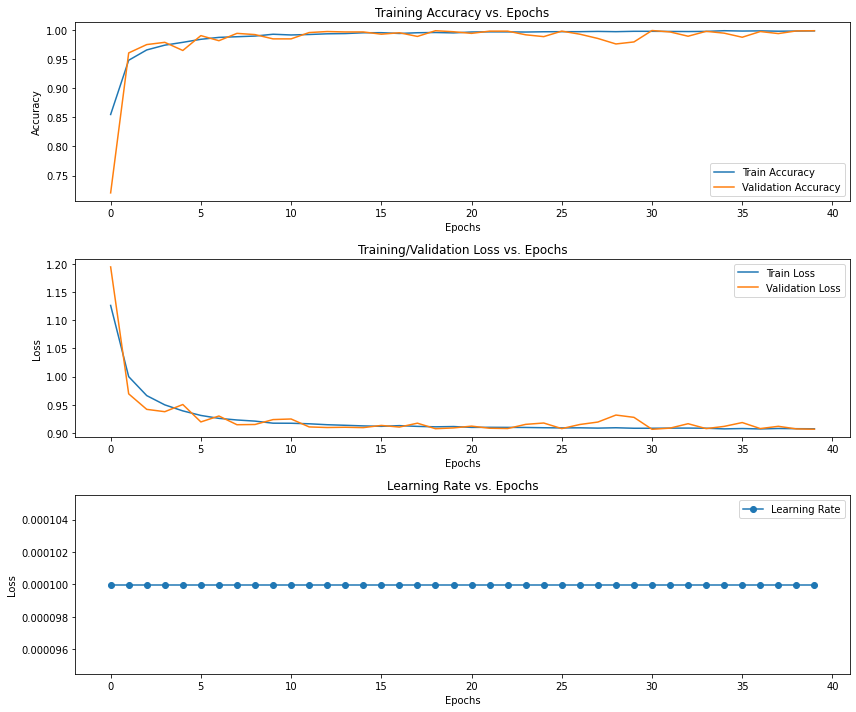

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model_mango.predict(test_gen)

In [ ]:
predictions.shape

(2867, 5)

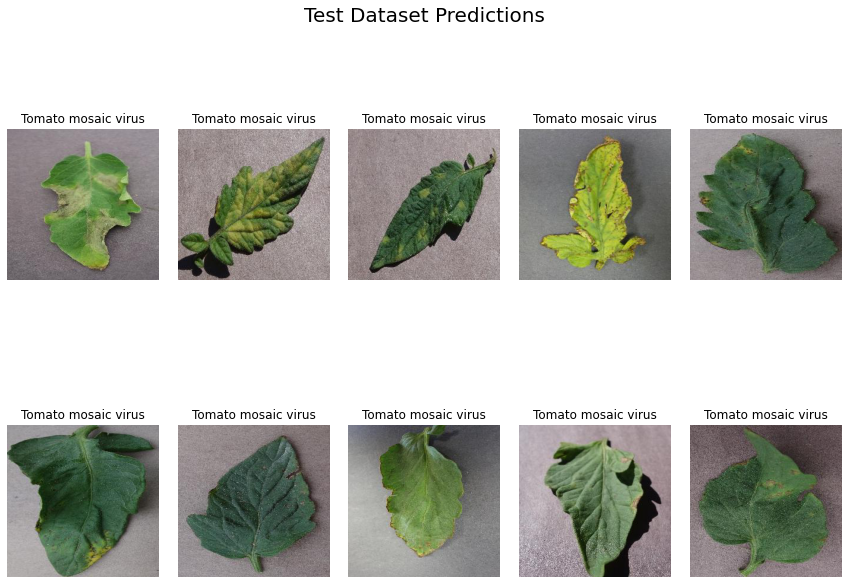

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_gen[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model_mango.evaluate(test_gen)

47/47 [==============================] - 12s 255ms/step - loss: 0.9085 - accuracy: 0.9969


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.9085449652468904
Test Accuracy: 0.9968608021736145


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes


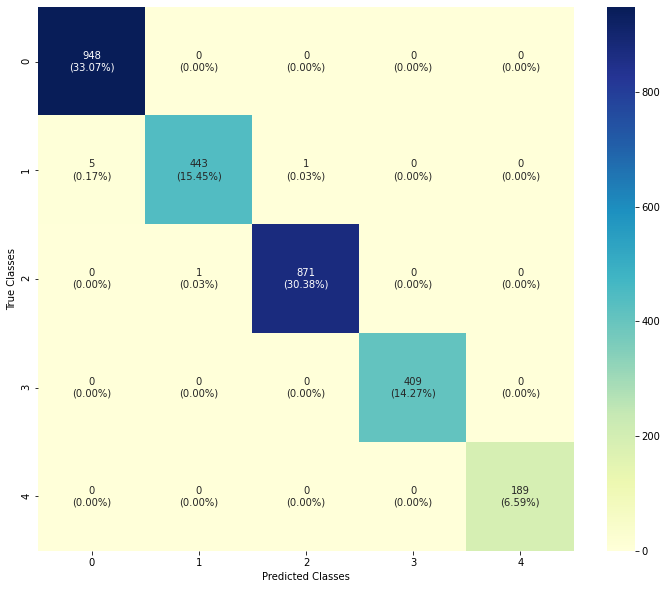

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, #xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       948
           1       1.00      0.99      0.99       449
           2       1.00      1.00      1.00       872
           3       1.00      1.00      1.00       409
           4       1.00      1.00      1.00       189

    accuracy                           1.00      2867
   macro avg       1.00      1.00      1.00      2867
weighted avg       1.00      1.00      1.00      2867



####